# Introduction into eye movement analysis

In the following short tutorial we will look into the basics of eye movement analysis. We will cover some fundamentals about the data and their structure, and then focus on the basic analysis of saccadic and pursuit eye movements. Saccades and pursuit are the two most important voluntary eye movement and typically constantly interact in the real world to allow us to direct our gaze at points of interest (see [here](https://www.sciencedirect.com/science/article/pii/S0042698921001851) for a recent review).

Following the basics of defining and detcting certain eye movements, we will look at other common analysis methods.

We will use some real data, we collected in previous experiments. This will contain the following topics:

Basics:
1.  Screen vs visual coordinates
2.  Filtering of Data

Saccades:
3.  Detecting saccades
4.  Computing some basic saccade parameters

Pursuit:
5.  Typical pursuit experiment
6.  Detecting pursuit eye movements
7.  Computing pursuit eye movement parameters

Typical Analyses:
8. Region of Interests

In the colab document you will often see sections that are not directly visible. Sometimes they contain helper functions or visualizations, then you can simply click the play button to execute them. If they contain solutions, you can also have a look at them by clicking on the respective button.

Across the notebook, you will have a number of tasks that you can do. Some will be simple questions that you can think about out, some are little coding exercises. They will be explained in more detail at the respective section.



In [1]:
## get the data from Github
!git clone https://github.com/AlexanderGoettker/EyeTrackingTutorial.git

from ctypes import cdll
#@title Import some general things you might need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pltrec
from matplotlib.widgets import Slider, Button, CheckButtons
import os
import scipy.io as sio
import glob
import pandas as pd
from ipywidgets import interact, interactive
from scipy import signal

from google.colab import output
output.enable_custom_widget_manager()

# Set the right path
print('Your working path is: ')
%cd EyeTrackingTutorial/


Cloning into 'EyeTrackingTutorial'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (477/477), done.
remote: Total 482 (delta 45), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (482/482), 7.27 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Your working path is: 
/content/EyeTrackingTutorial


# (1) Screen vs visual coordinates

When collecting data from a screen-based eye tracker, they will usually be in screen coordinates. Assume we have a monitor with 1920 x 1080 pixels. The default defintion is the following: The top left pixel will have the coordinate [0,0], the top right pixel the coordinate [1920,0]. The pixel in the bottom left of the monitor will have the coordinate [0,1080].


**Task:**

Some questions for you:

(a) What are the coordinates of the pixel in the bottom right corner?

(b) What are the coordinates of the pixel in the center of the screen?

In [ ]:
#@title For solutions click here

# (a) = [1920,1080]
# (b) = [960,540]

Now we know where people look on the screen in pixel coordinates, however this has two major disadvanatges when thinking about comparing results across different setups.

**Task:**

Can you think of the potential problems?

Think about....

How would a change in the resolution of the monitor affect your measurments?

What would be the influence of the viewing distance?


In [ ]:
#@title For solutions click here

# The pixel coordinates have the severe problem that a distance of 10 pixel can mean drastically different things!

# If you have a monitor with a different resolution (e.g. 3840 x 2160), a distance of 10 pixel suddenty would be much smaller
# If you move further away from the monitor, the same distance of 10 pixel will only cover a much smaller distance in the visual field

Now that we have seen that pixels might not be idea for an eye movement analysis, we will try to find a solution for that!

A common approach for this problem is to convert the data from pixel space into visual angles. For that we will use the things we know about the display and our viewing distance to convert a distance in pixel space into a distance in visual angles.

See some more detailed description [here](https://www.sr-research.com/eye-tracking-blog/background/visual-angle/) and visualization below.

(-0.5, 605.5, 447.5, -0.5)

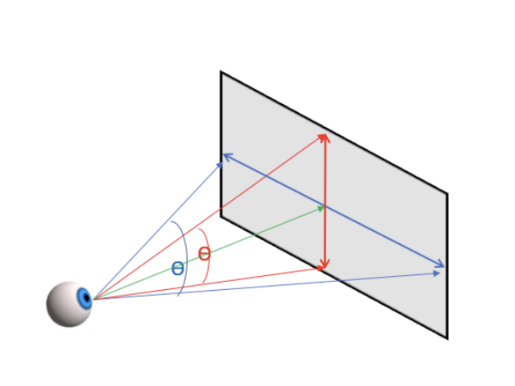

In [ ]:
#@title Show a visualization
%matplotlib inline
img = plt.imread('./Images/VisualAngles.png') # Read the image from the drive folder
plt.imshow(img)
plt.axis('off')

### **Convert pixel coordinates into visual angle**

Here are some example data that we can use for our test. You can see a visualization of the data in pixel coordinates below when running the plotting function and running the next code block.

In [ ]:
#@title Plotting function

def PixelPlot(xpos,ypos):

  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.plot(xpos,ypos)
  ax1.set_xlim(0,1920)
  ax1.set_ylim(0,1080)
  ax1.invert_yaxis()
  ax1.set_xlabel('X-Position[pixel]')
  ax1.set_ylabel('Y-Position[pixel]')

  ax2.plot(xpos)
  ax2.plot(ypos)
  plt.legend(['X-Position [pixel]', 'Y-Position [pixel]'])
  ax2.set_xlabel('Time in [ms]')

In [ ]:
## load the data
data = pd.read_csv('./Data/ExampleTrial.csv')
data_array = data.to_numpy()

## Plot them for visualization
xpos = data_array[1000:-1,1] # The x-position
ypos = data_array[1000:-1,2] # The y-position

PixelPlot(xpos,ypos) # use the pixel plot function to visualize the data


**Task:** Think about, what do the eyes do in this this trial?


In [ ]:
#@title Solution

#The data contain a single trial which starts in the lower half of the display and
#contains one saccade to the top left, followed by a second smaller saccade

**Task:**

Assume the follwing parameters for our setup:

Horizontal Pixel: 1920;
Vertical Pixel: 1080

Monitor Width: 70 cm; Monitor Height: 39.5 cm

Viewing Distance: 85 cm

The Convention for angular space is the following:

* 0,0 should be the center of the screen;

* positive x-values should be to the right;

* positive y-values should be to the left

Use this information to convert the pixel positions into visual angle. For that you need to add the conversion factor in the code block below.

You can find a solution to this problem below.

In [ ]:
#@title Plotting function

def AnglePlot(xpos,ypos):

  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.plot(xpos,ypos)
  ax1.set_xlim(-5,5)
  ax1.set_ylim(-10,10)
  ax1.set_xlabel('X-Position[deg]')
  ax1.set_ylabel('Y-Position[deg]')

  ax2.plot(xpos)
  ax2.plot(ypos)
  plt.legend(['X-Position [deg]', 'Y-Position [deg]'])
  ax2.set_xlabel('Time in [ms]')

Now here is some space to try to do this conversation yourself

In [ ]:
# xpos and ypos is the input of the x and y-position in pixel space

xdeg = ...## xdeg should be the x position in visual angle
ydeg = ...## ydeg should be the y position in visual angle

# hints you will need to use np.arctan as well as (180/np.pi) to change the output from radians into visual angle
# the eyes should start at roughly [0 deg,-8 deg] and end at [-3 deg, 0 deg]

# This will show you a plot visualizing your transformation
AnglePlot(xdeg,ydeg)

In [ ]:
#@title Solution

# Compute how much degree one single pixel is covering
# idea: Monitorsize/Pixels / Viewing distance is the critical triangle you need

ppd_x = np.arctan((70/1920)/85) * 180/np.pi# Pixel per Degree X
ppd_y = np.arctan((39.5/1080)/85)* 180/np.pi # Pixel per Degree X

# Now use that to convert the x and y position
xdeg = (xpos-(1920/2)) * ppd_x
ydeg = ((ypos-(1080/2)) * ppd_y)*-1 # you need to multiply it by -1 to make sure the axes are correct

AnglePlot(xdeg,ydeg) # use the pixel plot function to visualize the data


# (2) Filtering the data

As you might have noticed in the above plot, even during a fixation, there is some noise in the data which shows up in fast fluctuations in the eye position. This is partly due to tracker noise: Even if the eyes would point at the exact same position, the eye tracker sometimes might think the eyes look to the pixel to the right, or the pixel to the left. To reduce this noise a common technique is to digitally filter the data.

One of the most simplest filters is a moving average, but there are multiple other techniques as well (e.g. based on signal frequency). For illustration we  will stick with a moving average approach.

Activate the plotting function and look at the interactive plot below and change the window size...

(a) What do you think is a good window size for this data?

(b) Can you think what the term over-filtering might mean?

In [ ]:
#@title Plotting Function

def moving_average(arr,window_size):

    i = 0
  # Initialize an empty list to store moving averages
    moving_averages = []

  #  Loop through the array to consider
  # every window of size 3
    while i < len(arr) - window_size + 1:

    # Store elements from i to i+window_size
    # in list to get the current window
      window = arr[i : i + window_size]

    # Calculate the average of current window
      window_average = round(sum(window) / window_size, 2)

    # Store the average of current
    # window in moving average list
      moving_averages.append(window_average)

    # Shift window to right by one position
      i += 1
    return moving_averages


def filter_func(windowsize):
  fig, ax1 = plt.subplots()
  ax1.plot(xdeg,'k-')
  ax1.plot(ydeg,'k--')
  ax1.plot(moving_average(xdeg,windowsize),'b-')
  ax1.plot(moving_average(ydeg,windowsize),'b--')
  plt.legend(['Raw X-Position [deg]', 'Raw Y-Position [deg]','Filtered X-Position [deg]', 'Filtered Y-Position [deg]'])

  plt.grid()
  ax1.set_xlabel('Time [ms]')
  ax1.set_ylabel('Position [deg]')
  plt.show()



In [ ]:
## Show the interactive figure
plt.close('all')
interactive_plot = interactive(filter_func,windowsize=(1,150))
output = interactive_plot.children[-1]
interactive_plot

We will use the moving window filter for illustration here for the rest of the analysis, since it is more intuitive to understand. However, most commonly (at least for us), you use some frequency-based filter like a [Butterworth Filter](https://de.wikipedia.org/wiki/Butterworth-Filter) filter, which removes fast fluctuations in the data (--> noise). This helps with a reduction in a potential temporal shift of for example the onset of a saccade. In python it is implemented in the following way:


In [ ]:
## This is the butterworth filter
b,a = signal.butter(2, 20, 'low', fs=1000, output='ba') # Cutoff frequncy of 20 Hz for a sampling frequency of 1000 Hz
xdeg_filt = signal.filtfilt(b,a,xdeg) # Xposition in degree


## Make a plot to show the comparisons
fig, ax1 = plt.subplots()
ax1.plot(xdeg,'k-')
ax1.plot(xdeg_filt,'r--')
ax1.plot(moving_average(xdeg,10),'b--')
plt.legend(['Raw X-Position [deg]', 'Butterworth filter','Moving Average Filter'])
plt.grid()
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Position [deg]')
plt.show()



### Computing eye velocity

Filtering will become even more important when we look not simply at the position, but also at the eye velocity data.

A lot of labeling algorithms will use the eye velocity as criteria (see below). Activate the helper functions and play around with the following plot to see how the filter affects the velocity plot.

**Task:** Two questions here:

(a) How would you compute the velocity of the eye? --> You can try to find your own solution in the next code window

(b) Look at the interactive figure to see how the filter affects position and velocity. What do you notice?

(c) Based on the resulting velocity profile, can you already imagine how one would define a saccade?

In [ ]:
#@title HelperFunctions

def compute_vel(xpos,ypos):
  vel_x =np.diff(xpos)*1000 # Take the difference between each consecutive sample and multiply it by the sampling rate
  vel_y =np.diff(ypos)*1000
  vel = np.hypot(vel_x,vel_y) # The 2D velocity is given by the combination of the x and y velocity
  return vel

def vel_show(windowsize):

  fig, (ax1 , ax2)= plt.subplots(2,1)

  # Eye Position
  ax1.plot(xdeg,'k-')
  ax1.plot(ydeg,'k--')
  ax1.plot(moving_average(xdeg,windowsize),'b-')
  ax1.plot(moving_average(ydeg,windowsize),'b--')
  plt.legend(['Raw X-Position [deg]', 'Raw Y-Position [deg]','Filtered X-Position [deg]', 'Filtered Y-Position [deg]'])
  ax1.set_ylabel('Position [deg]')

  # Eye Velocity
  vel_unfiltered = compute_vel(xdeg,ydeg)
  vel_filtered = compute_vel(moving_average(xdeg,windowsize),moving_average(ydeg,windowsize))
  ax2.plot(vel_unfiltered,'k--')
  ax2.plot(vel_filtered,'b-')
  plt.legend(['Raw Velocity', 'Filtered Velocity'])
  ax2.set_xlabel('Time [ms]')
  ax2.set_ylabel('Velocity [deg/s]')

  plt.grid()
  plt.show()


In [ ]:
## Compute the regular velocity profile

###################################
#vel =  .... # You need to use the x and y position to compute that
             # Functions that might help: np.diff and np.hypot
##########################

vel = compute_vel(xdeg,ydeg) # Helper function with solution that you can use as well,

## Show the velocity profile based on the unfiltered data
fig, ax1 = plt.subplots()
ax1.plot(vel,'k-')
plt.grid()
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Eye Velocity [deg/s]')

In [ ]:
plt.close('all')
interactive_plot = interactive(vel_show,windowsize=(1,150))
output = interactive_plot.children[-1]
interactive_plot

# (3) Detecting saccades

Now that we have filtered the data and learned how to compute velocity, we can think about how we can use that signal to define the occurence of a saccade.

A common approach is to use a velocity threshold, every sample above a certain velocity is labelled as a saccade, every sample below that thresholdhold is labelled a fixation.

**Tasks:**

(a) Run the helper functions and use the interactive figure below to test what threshold seems reasonable. If a saccade is detected it will be shown in a shaded red area. Please note that the saccade detection is running on the filtered velocity

(b) Play around with the strength of the filter, what do you notice for the saccade labelling?

In [ ]:
#@title HelperFunctions

def detect_sacc(vel,threshold):

  check = np.where(vel >= threshold) # Find the points the velocity is over threshold
  Samples = check[0]

  SaccOn = [] # Get some empty lists
  SaccOff = []

  if len(Samples)> 0:

    i = 0 # Init index
    while 1: # Loop through the samples
      if i >= len(Samples)-1: # if you have reaches the end
        SaccOff.append(Samples[-1])
        break #exit

      if i == 0: # If you are at the first sample
        Start = Samples[i]
        SaccOn.append(Start)

      if Samples[i+1]-Samples[i] > 1: # Search for the end of the saccade
        SaccOff.append(Samples[i])
        Start = Samples[i+1]
        SaccOn.append(Samples[i+1])

      i = i+1 # Update the index

  return SaccOn, SaccOff


def plotSacc(windowsize,threshold):

  fig, ax1 = plt.subplots()

  vel_filtered = compute_vel(moving_average(xdeg,windowsize),moving_average(ydeg,windowsize))

  # Eye Velocity
  ax1.plot(vel,'k--')
  ax1.plot(vel_filtered,'b-')

  plt.legend(['Raw Velocity [deg/s]', 'Filtered Velocity [deg/s]'])
  ax1.set_ylabel('Velocity [deg/s]')

  # Add the Saccades
  [SaccOn, SaccOff] = detect_sacc(vel_filtered,threshold)

  if len(SaccOn) > 0:
    for aa,bb in enumerate(SaccOn): # add the labelled saccades
      Left = SaccOn[aa]-0.5
      rect= pltrec.Rectangle((Left,0), ((SaccOff[aa]-SaccOn[aa])),500, color = 'red',alpha = 0.5)
      ax1.add_patch(rect)

  plt.grid()
  plt.show()


In [ ]:
vel = compute_vel(xdeg,ydeg) # Helper function with solution

plt.close('all')
interactive_plot = interactive(plotSacc,windowsize=(1,150),threshold = (10,300))
output = interactive_plot.children[-1]
interactive_plot


# (4) Computing Saccade Parameter

Now that we have detected saccades, we are interested in quantifiying some saccade parameters. Common parameters are:

* Saccade Latency --> How faster a stimulus was shown the saccade is starting
* Saccade Amplitude --> The distance the saccade is covering
* Saccade Peak Velocity --> The peak velocity during the saccade
* Saccade Duration --> Duration of the saccade
* Saccade Accuracy --> Distance between saccade endpoint and target position
* Sacc Gain --> Amplitude of the saccade/ Amplitude of the target

A illustration of some of the parameters can be seen below and an example reference can be found [here](https://www.researchgate.net/figure/Saccadic-eye-movement-parameters-doi101371-journalpone0022410g002_fig7_51531251)

(-0.5, 665.5, 766.5, -0.5)

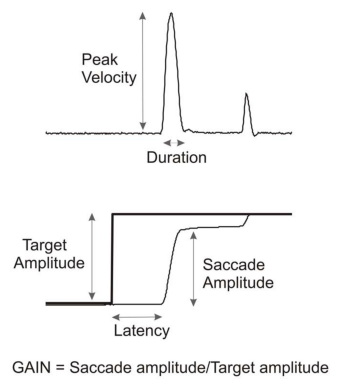

In [ ]:
#@title Show a visualization
%matplotlib inline
img = plt.imread('./Images/SaccParameter.jpg') # Read the image from the drive folder
plt.imshow(img)
plt.axis('off')

**Task:**
Take the first saccade we detect with a set off parameters and compute the parameter.

For that you can assume the following for the target position:
The target is initially presented at the coordinates **[0,-8]** and after **100 ms** jumps to the position **[-3,0]**.

You can add some code for that below. A solution is available below as well.

In [ ]:
## Here are the target characteristics:
InitialPos_x  = 0
InitialPos_y = -8
TargetPos_x = -3
TargetPos_y = 0
TargetOnset = 100

## Used Parameter
FilterWindow = 5 # Magnitude of the filter
VelocityThreshold = 30 # Velocity threshold

## Get the saccade onset and offset for a reasonable setting
vel = compute_vel(moving_average(xdeg,FilterWindow),moving_average(ydeg,FilterWindow)) # compute the velocity based on filtered data
[SaccOn, SaccOff] = detect_sacc(vel,VelocityThreshold) # Detect the saccades

SaccOnset = SaccOn[0] # Get the onset of first saccade
SaccOffset = SaccOff[0] # Get the offset of first saccade

# With the above variables you should now be able to compute all of the saccade parameter
Latency = ...
Amplitude = ...
PeakVel = ...
Duration = ...
SaccAccuracy = ...
SaccGain = ...

print(Latency, Amplitude, PeakVel, Duration, SaccAccuracy,SaccGain) # Show the parameters you computed


Ellipsis Ellipsis Ellipsis Ellipsis Ellipsis Ellipsis


In [ ]:
#@title Solution

## Here are the target characteristics:
InitialPos_x  = 0
InitialPos_y = -8
TargetPos_x = -3
TargetPos_y = 0
TargetOnset = 100

## Get the saccade onset and offset for a reasonable setting
vel = compute_vel(moving_average(xdeg,5),moving_average(ydeg,5))
[SaccOn, SaccOff] = detect_sacc(vel,30)

SaccOnset = SaccOn[0] # Get the first saccade
SaccOffset = SaccOff[0]

# With the above variables you should now be able to compute all of the saccade parameter
Latency = SaccOnset-TargetOnset
Amplitude = np.sqrt((xdeg[SaccOffset]-xdeg[SaccOnset])**2+(ydeg[SaccOffset]-ydeg[SaccOnset])**2)
PeakVel = np.max(vel[SaccOnset:SaccOffset])
Duration = SaccOffset- SaccOnset
SaccAccuracy = np.sqrt((xdeg[SaccOffset]-TargetPos_x)**2+(ydeg[SaccOffset]-TargetPos_y)**2)
SaccGain = Amplitude/ np.sqrt((InitialPos_x-TargetPos_x)**2+(InitialPos_y-TargetPos_y)**2)

print(Latency, Amplitude, PeakVel, Duration, SaccAccuracy,SaccGain)

227 8.666567118718874 463.89654018972806 34 0.4464090209012063 1.0143449578271209


## Bonus Task 1 ##

*The Saccade Main Sequence*

We know from previous research that saccades have a very stereotypical velocity profile, which can be described by the so called [main sequence](https://www.sciencedirect.com/science/article/pii/0025556475900759). This describes an almost linear relationship between the amplitude and peak velocity of the saccades.

(-0.5, 582.5, 428.5, -0.5)

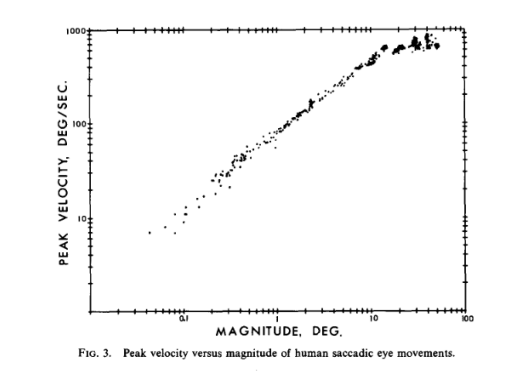

In [ ]:
#@title Show a visualization
%matplotlib inline
img = plt.imread('./Images/MainSequence.png') # Read the image from the drive folder
plt.imshow(img)
plt.axis('off')

**Task:**

 In the data folder you find a folder called main sequence, within there you find a lot of trials. Load all of them, complete the steps we just completed step by step to get the saccade parameter and then see whether you can replicate the main sequence.

 For that you need to:
 * Load the data
 * Convert them into visual angles
 * Compute the velocity
 * Detect the saccades
 * Compute the respective parameters and save them
 * In the end you can create a scatter plot to look at the results


 Note the following for the display parameter for the conversion into degree:
 Pixel_x = 3840
 Pixel_y = 2160
 Monitor_Width = 60 cm
 Monitor_Height = 32 cm
 ViewingDistance = 70 cm


In [ ]:
## Potentially helpful functions

# glob.glob --> Gives you the names of all files in a folder with a certain criterion
# sio.loadmat --> Loads .mat files into python --> to access the data you need to get the 'trial' values
# X-position should be in [:,4], Y-Position should be in [:,5] --> Again this will be initially in pixel

# For plotting: e.g plt.scatter(Amplitudes,Velocity) will give you a plot you want

In [ ]:

#@title Solution

def convert_deg(xpos,ypos):
  ppd_x = np.arctan((60/3840)/70) * 180/np.pi# Pixel per Degree X
  ppd_y = np.arctan((32/2160)/70)* 180/np.pi # Pixel per Degree X

  # Now use that to convert the x and y position
  xdeg = (xpos-(3840/2)) * ppd_x
  ydeg = ((ypos-(2160/2)) * ppd_y)*-1 # you need to multiply it by -1 to make sure the axes are correct

  return xdeg,ydeg

filenames = glob.glob('./Data/SaccadeFiles/*.mat')
plt.close('all')

# Init empty Lists
SaccAmp = []
SaccPeakVel = []
SaccDur = []

for aa,bb in enumerate(filenames):
    file = sio.loadmat(bb)
    dat = file['trial']

    xpos = dat[:,4]
    ypos = dat[:,5]

    # Convert to deg
    [xdeg,ydeg] =  convert_deg(xpos,ypos)

    # Compute Velocity and filter
    vel_filtered = compute_vel(moving_average(xdeg,5),moving_average(ydeg,5))

    # Get the saccades
    [SaccOn, SaccOff] = detect_sacc(vel_filtered,50)

    # Compute the parameter

    for aa,bb in enumerate(SaccOn):

      SaccOnset = SaccOn[aa] # Get the first saccade
      SaccOffset = SaccOff[aa]

    # With the above variables you should now be able to compute all of the saccade parameter
      if SaccOffset-SaccOnset > 0: # The saccade needs to be at least two frames long, otherwise it is probably just noise

        SaccAmp.append(np.sqrt((xdeg[SaccOffset]-xdeg[SaccOnset])**2+(ydeg[SaccOffset]-ydeg[SaccOnset])**2))
        SaccPeakVel.append(np.max(vel_filtered[SaccOnset:SaccOffset]))
        SaccDur.append(SaccOffset- SaccOnset)


## Plot everything
fig, (ax1 , ax2)= plt.subplots(1,2)

ax1.scatter(SaccAmp,SaccPeakVel)
ax1.set_xlabel('Saccade Amplitude [deg]')
ax1.set_ylabel('Peak Velocity [deg/s]')

ax2.scatter(SaccDur,SaccPeakVel)
ax2.set_xlabel('Saccade Duration [ms]')

# (5) A typical pursuit experiment ##

After working with saccades, we now turn to the second type of voluntary eye movement: Pursuit eye movements. In contrast to saccades, which are mostly investigated with static stimuli, pursuit is usually measured with moving targets. Here you can see the eye trace in a single trial.

**Question:**

What happens in this trial?



In [3]:
#@title Activate Plotting function

def PixelPlot(xpos,ypos):

  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.plot(xpos,ypos)
  ax1.set_xlim(0,1920)
  ax1.set_ylim(0,1080)
  ax1.invert_yaxis()
  ax1.set_xlabel('X-Position[pixel]')
  ax1.set_ylabel('Y-Position[pixel]')

  ax2.plot(xpos)
  ax2.plot(ypos)
  plt.legend(['X-Position [pixel]', 'Y-Position [pixel]'])
  ax2.set_xlabel('Time in [ms]')

In [ ]:
## load the data
data = sio.loadmat('./Data/ExampleTrialPurs.mat')
dat = data['trial']

## Plot them for visualization
xpos = dat[:,1] # The x-position
ypos = dat[:,2] # The y-position
PixelPlot(xpos,ypos) # use the pixel plot function to visualize the data


In [ ]:
#@title Solution:

# You see that the eyes are at the center of the screen and then move smoothly to the right after about 1500 ms

**Task**

Ok, now we again need to perform the same basic steps as for the saccade data.
We want to:

(1) Convert the data into visual angle (assuming the same settings as above for the example trial)
Horizontal Pixel: 1920; Vertical Pixel: 1080; Monitor Width: 70 cm; Monitor Height: 39.5 cm

Viewing Distance: 85 cm

(2) Filter the position trace with a Butterworth filter

(3) Compute the eye velocity

In [ ]:
## Variables at the beginning: xpos and ypos are the x and y-position in pixel
## Variables we need: xdeg and ydeg as the filtered eye position in degrees and vel as the eye velocity

xdeg = ...
ydeg = ...
vel = ...

In [7]:
#@title Solution:

###############################################################################
##########################Define Functions ####################################
###############################################################################

def convert_deg(xpos,ypos):
  ppd_x = np.arctan((70/1920)/85) * 180/np.pi# Pixel per Degree X
  ppd_y = np.arctan((39.5/1080)/85)* 180/np.pi # Pixel per Degree X

  # Now use that to convert the x and y position
  xdeg = (xpos-(1920/2)) * ppd_x
  ydeg = ((ypos-(1080/2)) * ppd_y)*-1 # you need to multiply it by -1 to make sure the axes are correct

  return xdeg,ydeg

def filter(xdeg,ydeg):
  b,a = signal.butter(2, 20, 'low', fs=1000, output='ba') # Cutoff frequncy of 20 Hz for a sampling frequency of 1000 Hz
  xdeg = signal.filtfilt(b,a,xdeg) # Xposition in degree
  ydeg = signal.filtfilt(b,a,ydeg) # Xposition in degree

  return xdeg,ydeg

def compute_vel(xdeg,ydeg):
  vel_x =np.diff(xdeg)*1000 # Take the difference between each consecutive sample and multiply it by the sampling rate
  vel_y =np.diff(ydeg)*1000
  vel = np.hypot(vel_x,vel_y) # The 2D velocity is given by the combination of the x and y velocity
  return vel


###############################################################################
########################## Perform the operations #############################
##############################################################################

[xdeg,ydeg] = convert_deg(xpos,ypos) # Conversion
[xdeg,ydeg] = filter(xdeg,ydeg)
vel = compute_vel(xdeg,ydeg)

In [ ]:
## Visualize it to check whether it is working

fig, (ax1 , ax2)= plt.subplots(2,1)

# Eye Position
ax1.plot(xdeg,'b-')
ax1.plot(ydeg,'r-')
plt.legend(['X-Position [deg]', 'Y-Position [deg]'])
ax1.set_ylabel('Position [deg]')

  # Eye Velocity
ax2.plot(vel,'k-')
plt.legend(['Velocity [deg/s]'])
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Velocity [deg/s]')

plt.grid()
plt.show()


# (6) Detecting Pursuit eye movements

Great! Now we have our eye velocity in a given trial. For ease we assume that the target started moving after 1400 ms in the trial and moved at 12 deg/s.

Now we need to find the onset of pursuit eye movement! A common way of approaching this is finding the first point in time where the eye velocity is higher than a certain threshold and stays there for at least 100 ms. Typical values used for a threshold are 30% of the target velocity or higher than the mean eye velocity during fixation + 2 std.



In [5]:
#@title Solution:
def detect_purs(vel,targetvel):

  time = 0 # set the search to the beginning of the vector

  # You can choose between the two different threshold
  Threshold = 0.3 * targetvel # Proportion of target velocity
  #Threshold = np.mean(vel[0:100])+2*np.std(vel[0:100]) # Outlier for fixation velocity

  PursCounter = 0 # Counter for pursuit duration

  while 1:

    if vel[time] > Threshold: # Check whether eye velocity fulfills the pursuit criteria
      PursCounter += 1
    else:
      PursCounter = 0

    if PursCounter >= 100: # If you have 100 consecutive frames over the threhold.. you found your onset
        PursOn = time-100
        break

    time +=1 # update the search time

    if time > len(vel)-1: # if you are at the end and didnt find a pursuit onset and it as well
        PursOn = np.nan
        break

  return PursOn

In [ ]:
vel_purs = vel[1400:-1]
TargetSpeed = 12

## Detect pursuit onset relative to the motion onset

## Space for your own code ####


## This is the solution #################
#Onset = detect_purs(vel_purs,TargetSpeed) #Solution function

In [ ]:
## Visualize to check whether it is correct

fig, (ax1)= plt.subplots(1,1)

ax1.plot(vel_purs,'k-')
ax1.vlines(x = Onset, ymin = 0, ymax = 30, color = 'r')
plt.legend(['Velocity', 'Pursuit Onset'])
ax1.set_ylabel('Velocity')
ax1.set_xlabel('Time after motion onset [ms]')


# (7) Computing pursuit parameter

now that we have the pursuit onset, we can look at typical parameters that are computed.
These include:

**Pursuit Latency:** Onset of pursuit relative to motion onset

**Pursuit Gain:** Velocity of the eye (typically between 100 and 200 ms after pursuit onset) relative to the target velocity

**Pursuit Acceleration:** Often estimated by slope of a line fitted to the eye velocity around the detected pursuit onset (+/- 25 ms). Keep in mind that you want to report this in deg/s²



 **Task:** For the given trial, please compute these parameter.

In [ ]:
Latency = ...
Gain = ...
Acceleration = ...  # np.polyfit might be very helpful...

print(Latency,Gain, Acceleration)


Ellipsis Ellipsis Ellipsis


In [ ]:
#@title Solution:
Latency = Onset # Onset is already now defined with respect to the motion onset
Gain = np.mean(vel_purs[Onset+100:Onset+200])/TargetSpeed

time = np.arange(0,len(vel_purs[Onset-25:Onset+25]))
Fit = np.polyfit(time,vel_purs[Onset-25:Onset+25],1) # This gives us the slope as first parameter, but this is now still the change per ms, we want that per second..
Acceleration = Fit[0]*1000

print(Latency,Gain, Acceleration)


182 0.9747242495289345 86.7902884866529


## Bonus Task 2 ##

In the folder with pursuit files, you will find a bunch of data that all contain individual pursuit trials in response to different target velocities. Try to compute the parameter for each trial and group them based on the target velocity. You can also save the individual velocity traces to see how eye velocity evolves depending on the target velocity


In [ ]:
## Things you need to know for this:
#The folder contains a log file, where you can find the movement direction of the target in column 8  and the speed of the target in column 9
#For each trial in the log file (100 trials), there is one specific mat file that contains the eye movement data in the above established format
# xposition of gaze in pixels is in column 2
# yposition of gaze  in pixels is in colum 3
# target motion onset is the moment where the second 1 appears in column 4

# Hint: Since the target is moving horizontally, lets use only the horizontal velocity ! However for this we need to align targets movements moving to the left and to the right
# --> We can do this by flipping target movements to the left (direction in this trial will be 180)



In [ ]:
#@title Solution:

def compute_vel_hor(xdeg):
  vel_x =np.diff(xdeg)*1000 # Take the difference between each consecutive sample and multiply it by the sampling rate
  return vel_x

plt.close('all')
######################################################################################################
############### Initiate and get files  ##########################################

logname = glob.glob('./Data/PursuitFiles/*.log')
filenames = glob.glob('./Data/PursuitFiles/*.mat')
## Read the trial information from the logfile
logfile = np.asarray(pd.read_table(logname[0],header=None)) # Get the logfile
direction = logfile[:,8] # Direction information is in colum 9
speed = logfile[:,9] # Direction information is in colum 10

# Init empty arrays
BadTrial = np.zeros((100))
PursLatency = np.zeros((100))
PursGain = np.zeros((100))
PursAcc = np.zeros((100))
PursVel = np.zeros((400,100))


######################################################################################################
############### Analyze each trial ##########################################


for aa,bb in enumerate(filenames): #Analyze all trials

    file = sio.loadmat('./Data/PursuitFiles/trial'+str(aa+1)+'.mat')
    dat = file['trial']

    xpos = dat[:,4] # The x-position
    ypos = dat[:,5] # The y-position

    events = dat[:,3] # the column defining events
    idx = (np.where([events == 1]))
    idx = idx[1]
    Onset = idx[1] # Get the onset

    [xdeg,ydeg] = convert_deg(xpos,ypos) # Conversion
    [xdeg,ydeg] = filter(xdeg,ydeg) # Filtering

    # Flip the direction of the x position to align all target movements to the right
    if direction[aa] == 180:
      xpos = xpos*-1


    vel = compute_vel_hor(xdeg) # Compute the velocity

    # Align Target Movements on motion onset:
    vel_purs = vel[Onset:Onset+400]

    # Save the velocity
    PursVel[:,aa] = vel_purs

    # Get the pursuit onset
    Onset = detect_purs(vel_purs,speed[aa]) #Solution function

    PursLatency[aa] = Onset
    if PursLatency[aa] > 50 and PursLatency[aa] < 350: # If purs latency is inline with your criteria

      PursGain[aa] = np.median(vel_purs[Onset+100:Onset+200])/speed[aa] # Compute Gain

      time = np.arange(0,len(vel_purs[Onset-25:Onset+25]))
      Fit = np.polyfit(time,vel_purs[Onset-25:Onset+25],1) # This gives us the slope as first parameter, but this is now still the change per ms, we want that per second..
      PursAcc[aa] = Fit[0]*1000

    else:
      BadTrial[aa] = 1


######################################################################################################
############### Now look at the results split by velocity ##########################################

# Init things
Speeds = np.unique(speed)
MeanLat = np.zeros((5))
MeanGain = np.zeros((5))
MeanAcc = np.zeros((5))
MeanVel = np.zeros((400,5))
Time = np.arange(0,400)

# Define plotting colors
Colors = np.array([[0.8431,   0.0980,    0.1098],
    [0.9922,    0.6824,    0.3804],
    [1.0000,    1.0000,  0.7490],
    [0.6706,    0.8667,    0.6431],
    [0.1686,    0.5137,    0.7294]]
)

fig, (ax1 , ax2)= plt.subplots(1,2,figsize = (15,5))
fig, (ax3 , ax4, ax5)= plt.subplots(1,3,figsize = (15,5))

for aa,bb in enumerate(Speeds): # Loop across the speeds

    # Find the relevant trials
    idx = np.where(np.logical_and(speed == bb, BadTrial == 0))

    # Compute the median parameter
    MeanLat[aa] = np.median(PursLatency[idx])
    MeanGain[aa] = np.nanmedian(PursGain[idx])
    MeanAcc[aa] = np.median(PursAcc[idx])


    test= np.median(np.squeeze(PursVel[:,idx]),axis =1)
    MeanVel[:,aa] =np.median(np.squeeze(PursVel[:,idx]),axis = 1)

    # Create plot with all velocities
    ax1.plot(Time,np.squeeze(PursVel[:,idx]),'-', color= Colors[aa,:],alpha = 0.5) # Individual Traces
    ax1.set_ylabel('Velocity')
    ax1.set_xlabel('Time after motion onset [ms]')
    ax1.set_ylim((-5, 20))

    # Average traces
    ax2.plot(Time,MeanVel[:,aa] ,'-', color= Colors[aa,:],linewidth=5)
    ax2.legend(['Speed: 8.4 deg/s', 'Speed: 9.2 deg/s','Speed: 10 deg/s','Speed: 10.8 deg/s','Speed: 11.6deg/s'])
    ax2.set_ylabel('Average Velocity [deg/s]')
    ax2.set_xlabel('Time after motion onset [ms]')

    # Show the mean parameter
    ax3.plot(Speeds[aa],MeanLat[aa],'o', color= Colors[aa,:])
    ax3.set_ylabel('Mean Latency')
    ax3.set_xlabel('Target Velocity [deg/s]')
    ax3.set_ylim((100, 250))

    ax4.plot(Speeds[aa],MeanGain[aa],'o', color= Colors[aa,:])
    ax4.set_ylabel('Mean Gain')
    ax4.set_xlabel('Target Velocity [deg/s]')
    ax4.set_ylim((0.8, 1.3))

    ax5.plot(Speeds[aa],MeanAcc[aa],'o', color= Colors[aa,:])
    ax5.set_ylabel('Mean Acceleration')
    ax5.set_xlabel('Target Velocity [deg/s]')
    ax5.set_ylim((50, 100))


## Addition: Interpolation of data  

One thing to note is that here you also still see one trial, where there is probably a initial saccade in the pursuit response. A common approach is to remove saccades from the velocity trace by lineraly interpolating the velocity vector between the onset and end of the detected saccade. Please note that here you usually would not do this from the actual detected onset and offset, but with some additional buffer of 10-20 ms.

A similar approach is often taken during blinks. Also missing data during blinks is often lineraly interpolated in the positon trace.

# (8) Region of Interests

One very common analysis you will find in a lot of different eye tracking papers, is the so called region of interest (ROI) analysis. Here people are interest in how long people spent looking at certain regions in an image, which is for example very popular in marketing research (How long did a consumer look at my product ?).

For this we will first need to load a stimulus, usually in a lab setting this will be a static image. In our case, we will use the image below of an artifically created face.



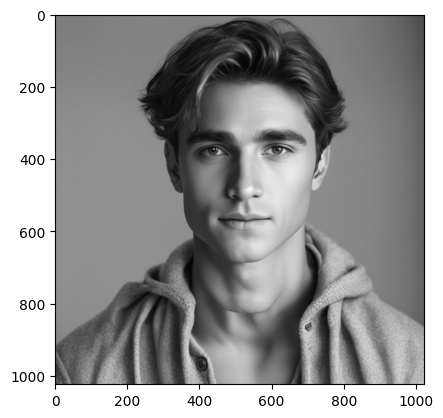

In [ ]:
## Show the image

img = plt.imread('./Data/ROIFiles/AIFace.jpeg') # Read the image from the drive folder
plt.imshow(img)

Now we can load the eye movement data for one observer watching this image for five seconds and visualize it as well.

In [ ]:
file = sio.loadmat('./Data/ROIFiles/trial1.mat')
dat = file['trial']

xpos = dat[:,4] # The x-position
ypos = dat[:,5] # The y-position

## One thing we need to note the images was only shown at the second event, therefore we will cut the position

events = dat[:,3] # the column defining events
idx = (np.where([events == 1]))
idx = idx[1]
Onset = idx[1] # Get the onset

xpos = xpos[Onset:-1]
ypos = ypos[Onset:-1]

plt.figure()
plt.plot(xpos,ypos,'o')

Good news first: Since we are interested in relating the eye positions to the image, we can keep the data in pixel coordinates for now.

However, now that we have the image and the according eye movement trace, there might be something you noticed:
The two coordinate systems do not align. The image has the size of 1024 x 1024 pixes, but the eye tracking coordinates are with respect to the whole screen and live in the space of 1920 x 1080 pixels.

How can we align the two, assuming the images was presented centered on the computer screen?


In [ ]:
# Add the transformation to match the coordinate systems
xpos = ...
ypos = ...

In [ ]:
#@title Solution:
## We need to recenter the 0,0 coordinate to the upper left pixel of the image, by shifting everything by the empty space on the screen to the left and on top of the image
xpos = xpos-((1920-1024)/2)
ypos = ypos-((1080-1024)/2)

In [ ]:
## Check whether they now align:

plt.imshow(img)
plt.plot(xpos,ypos,'ko')


Great ! That looks reasonable now. So now we can actually perform the region of interest analysis. For this you need to define a space in the image that you are interested in and then compute how much time people spent looking at this region.

For our example, lets define two regions of interest for testing:

(a) The eyes of the person

(b) the weird deformation on the throat

For that we need to know the pixel coordinates of the ROI. You could use computer vision to define relevant objects in pixel space, or manually label them for individual images.

For our purposes you can work with these coordinates in the following order:
left border, upper border, right border, lower border

**Left eye:** 384, 357, 485, 409

**Right eye:** 572, 355, 670, 405

**Deformation:** 430, 741, 658, 821




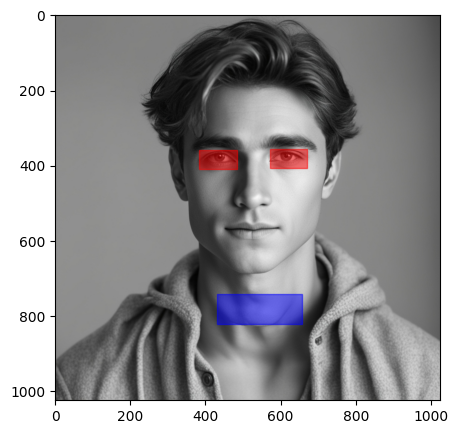

In [ ]:
#@title Visualize the ROI

fig, ax1= plt.subplots(1,1,figsize = (15,5))

ax1.imshow(img)
rect= pltrec.Rectangle((384,357), 485-384,409-357, color = 'red',alpha = 0.5)
ax1.add_patch(rect)
rect= pltrec.Rectangle((572,355), 670-572,405-355, color = 'red',alpha = 0.5)
ax1.add_patch(rect)
rect= pltrec.Rectangle((430,741), 658-430,821-741, color = 'blue',alpha = 0.5)
ax1.add_patch(rect)


**Task:**

Ok great, now we need to look at how long people long into the ROIs. Remember each sample is 1 ms worth of data.

In [ ]:
Left_eye = ...

Right_eye = ...

Deformation = ...

print('The person looked at the eyes for ' + str(Left_eye+Right_eye), ' ms')
print('The person looked at the deformation for ' + str(Deformation), ' ms')

In [ ]:
#@title Solution

# Left eye
X = np.logical_and(xpos > 384, xpos < 485) # X in the relevant samples
Y = np.logical_and(ypos > 375, ypos < 409) # Y in the relevant samples
Left_eye = np.size(np.where(np.logical_and(X,Y))) # This is the duration people looked into the left eye

# Right eye
X = np.logical_and(xpos > 572, xpos < 670)
Y = np.logical_and(ypos > 355, ypos < 405)
Right_eye = np.size(np.where(np.logical_and(X,Y))) # This is the duration people looked into the left eye

# Deformation
X = np.logical_and(xpos > 430, xpos < 658)
Y = np.logical_and(ypos > 741, ypos < 821)
Deformation = np.size(np.where(np.logical_and(X,Y))) # This is the duration people looked into the left eye

print('The person looked at the eyes for ' + str(Left_eye+Right_eye), ' ms')
print('The person looked at the deformation for ' + str(Deformation), ' ms')


Instead of using raw time values, you will also often see ROI values as proportion of absolute time, e.g. the person spend 20% of their time looking at the eyes. In our case that would just simply mean, dividing the obtained time by 5000 ms as the image was presented for 5s.

### Heatmaps

One very common  technique to illustrate gaze data are [heatmaps](https://www.researchgate.net/figure/Heat-map-visualization-of-the-gaze-behavior-for-human-color-images-On-the-left-is-a_fig16_225059658).


Here you overlay some kind of color map ontop of an image, where warmer/brighter colors usually indicate regions that are fixated for a longer time. Therefore, they are vary closely related to your typical ROI analysis.

However here instead of featuring only specific regions of the image, you compute the proportion of time people are looking at different position all across the image.

There are mostly two different techniques of how you can sample the image:

(a) You create a square grid aross the whole image (similar to a checker board) and measure how much time people spent in each of these squares. The overlay this a surface plot on top of the image.

(b) you create a similar grid, but instead of looking at seperates squares, you look at how many data points fall within a certain distance of the grid points. This will look similar to a checker board, but with overlapping circles.



### Bonus Task 3: For the image above, visualize the data using a heatmap.

In [ ]:
### Here is your space to try

In [ ]:
#@title Solution

from matplotlib import cm

## Specifications of the HeatMaps
Integrate = 30; # Pixels that you integrate over
xvek = np.arange(0,1024,10)  # Grid for the heatmaps
yvek = np.arange(0,1024,10) # Grid for the heatmaps
GazeMap = np.zeros((int(len(xvek)),int(len(yvek)))) # Matrix for saving the data


# Now for each point in the grid look for the proportion of data points

for aa,xx in enumerate(xvek):
  for bb,yy in enumerate(yvek):

    # compute the distance of each sample to the current grid location
    Dist = np.sqrt((xpos-xx)**2+ (ypos-yy)**2)
    Samp = np.size(np.where(Dist < Integrate))
    # Save the number of samples within that range
    GazeMap[bb,aa] = Samp


# Make the surface plot
X, Y = np.meshgrid(xvek, yvek)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_aspect('equal')

# Plotting the surface plot
surf = ax.plot_surface(X, Y, GazeMap.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Setting the view
ax.view_init(elev=90, azim=0)
# Setting color limits
ax.set_xlim([min(xvek), max(xvek)])
ax.set_ylim([min(yvek), max(yvek)])
ax.set_xlabel('Y-Axis')
ax.set_ylabel('X-Axis')
